In [19]:
from pathlib import Path
import matplotlib.pyplot as plt
import trompy as tp
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
%matplotlib inline

In [20]:
DATAPATH = Path("C://Data//hislight_pickles//HL3_restricted_dark.pickle")

with open(DATAPATH, 'rb') as handle:
    HL3_restricted = pickle.load(handle)

In [21]:
mouse_to_be_analyzed = "HL304"

In [22]:
def get_snips(data, mouse):
    
    snips_start = []
    snips_end = []
    snips_full = []

    kwargs={"bins":150, "trial_length":15, "baseline_length":5}   

    pre = 5
    post = 10
    mineventlength=10
    binlength=0.1

    for key, val in data.items():
        if val["mouse_ID"]==mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata= tp.lickCalc(val["licks"], minrunlength=3)

            snips_start.append(tp.snipper(val["corrected"], lickdata["rStart"], val["fs"], **kwargs)[0])
            snips_end.append(tp.snipper(val["corrected"], lickdata["rEnd"], val["fs"], **kwargs)[0])

            snipper = tp.Snipper(val["corrected"],
                                    lickdata["rStart"],
                                    end=lickdata["rEnd"],
                                    fs=val["fs"],
                                    pre=pre,
                                    post=post,
                                    binlength=binlength,
                                    zscore=True
                                    )

            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=mineventlength)
            snipper.find_potential_artifacts(threshold=8, method="sum")
            snips_full.append(snipper.snips)


    snips_start = np.vstack(snips_start)
    snips_end = np.vstack(snips_end)

    try:
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except:
        print("no snips to concatenate")


    return snips_start, snips_end, snips_full

In [23]:
snips_start, snips_end, snips_full = get_snips(HL3_restricted, mouse_to_be_analyzed)

<class 'numpy.ndarray'>
Found 11 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
no snips to concatenate


IndexError: Inconsistent shape between the condition and the input (got (3, 1) and (3,))

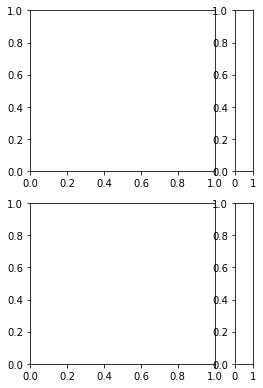

In [24]:
f,[[ax1, ax2], [ax3, ax4]]=plt.subplots(nrows=2, ncols=2,
                                        figsize=[4,6.5],
                                        gridspec_kw={"width_ratios":[10,1]})

pre = 5
post = 10
mineventlength=10
binlength=0.1

sns.heatmap(snips_full, ax=ax1, cbar_ax= ax2, cmap="RdBu_r", vmax=2, vmin=-2, cbar_kws={"ticks": [2, 0, -2]})

bins_early = int((pre + mineventlength/2)/binlength)
bins_late = int((post + mineventlength/2)/binlength)

x1 = np.arange(0,bins_early)
x2 = np.arange(snips_full.shape[1] - bins_late, snips_full.shape[1])

mean = np.mean(snips_full, axis=0)
error_values = np.std(snips_full, axis=0) / np.sqrt(len(snips_full))

color="#219C90"

ax3.plot(x1, mean[:bins_early], color=color)
ax3.plot(x2, mean[-bins_late:], color=color)
ax3.fill_between(x1, mean[:bins_early]-error_values[:bins_early], mean[:bins_early]+error_values[:bins_early], color=color, alpha=0.3)
ax3.fill_between(x2, mean[-bins_late:]-error_values[-bins_late:], mean[-bins_late:]+error_values[-bins_late:], color=color, alpha=0.3)


# tp.shadedError(ax3, snips_full)
ax4.remove()

ax1.set_yticks([])
ax1.set_xticks([])
ax1.axvline(50, color="yellow")
ax1.axvline(160, color="yellow")

ax3.set_yticks([])
ax3.set_xticks([])

ax1.set_ylabel("trials")

for spine in ["top", "right", "left", "bottom"]:
    ax3.spines[spine].set_visible(False)

ax3.plot([200,250], [-1,-1], linewidth=2, color="k")
ax3.text(225,-1.1,"5 s", va="top", ha="center")

ax3.plot([0,0], [0.5, 1.5], linewidth=2, color="k")
ax3.text(-3, 1, "1 Z", va="center", ha="right")

ax3.axvline(50, color="k", linestyle="--", alpha=0.5)
ax3.axvline(160, color="k", linestyle="--", alpha=0.5)

#f.savefig("C:\\Users\\kvo019\\OneDrive - UiT Office 365\\Pipette 2\\People\\Linnea\\Manuscripts\\hislight paper\\figures\\HL3_representative.pdf")

In [ ]:
AUC_start = np.trapz(snips_start[:,50:])
AUC_end = np.trapz(snips_end[:,50:])

NameError: name 'run_length' is not defined

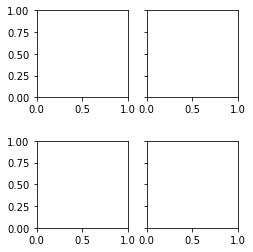

In [14]:
f,[[ax1, ax2], [ax3, ax4]]=plt.subplots(nrows=2, ncols=2,
                                        figsize=[4,4],
                                        gridspec_kw={"width_ratios":[1,1], "left":0.2, "hspace":0.5},
                                       sharey=True)


ax1.scatter(run_length, AUC_start, alpha=0.3, color= "#219C90")
ax3.scatter(run_licks, AUC_start, alpha=0.3, color= "#219C90")

ax2.scatter(run_length, AUC_end, alpha=0.3, color= "#219C90")
ax4.scatter(run_licks, AUC_end, alpha=0.3, color= "#219C90")

ax1.axhline(0, color="black", linestyle="--", linewidth=0.5)
ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
ax3.axhline(0, color="black", linestyle="--", linewidth=0.5)
ax4.axhline(0, color="black", linestyle="--", linewidth=0.5)

ax1.set_xlabel("run length (s)")
ax3.set_xlabel("# licks")
ax2.set_xlabel("run length (s)")
ax4.set_xlabel("# licks")

ax1.set_ylabel("AUC")
ax3.set_ylabel("AUC")
#ax2.set_ylabel("AUC")
#ax4.set_ylabel("AUC")

for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1.set_title("run start")
ax2.set_title("run end")



#f.savefig("C:\\Users\\kvo019\\OneDrive - UiT Office 365\\Pipette 2\\People\\Linnea\\Manuscripts\\hislight paper\\figures\\HL3_rep_runs_vs_AUC.pdf")

In [ ]:
from sklearn.metrics import r2_score

def best_fit(x, slope, intercept):
    return slope*np.array(x)+intercept

slope, intercept = np.polyfit(run_length, AUC_end,1)
y_pred= best_fit(run_length, slope, intercept)
r2=r2_score(AUC_end, y_pred)

In [25]:
r2

0.09697485064353728

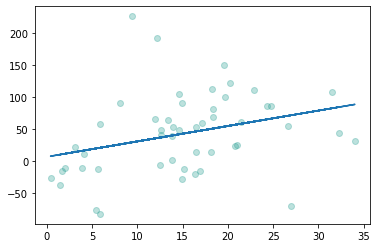

In [29]:
f,ax=plt.subplots()

ax.scatter(run_length, AUC_end, alpha=0.3, color= "#219C90")
ax.plot(run_length, y_pred)